In [1]:
import logging
import numpy as np
from collections import Counter
import tqdm
from detectron2 import model_zoo
import os
from matplotlib.pyplot import figure
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.engine import default_argument_parser
from detectron2.modeling import build_model
from detectron2.utils.analysis import (
    activation_count_operators,
    flop_count_operators,
    parameter_count_table,
)
import copy
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw,ImageEnhance,ImageColor 
from detectron2.utils.logger import setup_logger
from detectron2.engine.defaults import DefaultPredictor
logger = logging.getLogger("detectron2")
import random
from detectron2.data.catalog import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
register_coco_instances("boat_train", {}, "/home/q/4t/detectron2/a/boat/annotations/instances_boat_train2020.json", "/home/q/4t/detectron2/a/boat/train/")
register_coco_instances("boat_val", {}, "/home/q/4t/detectron2/a/boat/annotations/instances_boat_val2020.json", "/home/q/4t/detectron2/a/boat/val/")
import cv2
from fastprogress import progress_bar
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def setup(args):
    cfg = get_cfg()
    cfg.merge_from_file(args.config_file)
    cfg.DATALOADER.NUM_WORKERS = 0
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    setup_logger()
    return cfg


def do_flop(cfg):
    data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
    model = build_model(cfg)
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
    model.eval()

    counts = Counter()
    total_flops = []
    for idx, data in zip(tqdm.trange(args.num_inputs), data_loader):  # noqa
        count = flop_count_operators(model, data)
        counts += count
        total_flops.append(sum(count.values()))
    logger.info(
        "(G)Flops for Each Type of Operators:\n" + str([(k, v / idx) for k, v in counts.items()])
    )
    logger.info("Total (G)Flops: {}±{}".format(np.mean(total_flops), np.std(total_flops)))


def do_activation(cfg):
    data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
    model = build_model(cfg)
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
    model.eval()

    counts = Counter()
    total_activations = []
    for idx, data in zip(tqdm.trange(args.num_inputs), data_loader):  # noqa
        count = activation_count_operators(model, data)
        counts += count
        total_activations.append(sum(count.values()))
    logger.info(
        "(Million) Activations for Each Type of Operators:\n"
        + str([(k, v / idx) for k, v in counts.items()])
    )
    logger.info(
        "Total (Million) Activations: {}±{}".format(
            np.mean(total_activations), np.std(total_activations)
        )
    )


def do_parameter(cfg):
    model = build_model(cfg)
    logger.info("Parameter Count:\n" + parameter_count_table(model, max_depth=5))


def do_structure(cfg):
    model = build_model(cfg)
    logger.info("Model Structure:\n" + str(model))

In [2]:
cfg = get_cfg()
cfg.merge_from_file(r"/home/q/4t/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("boat_train",)
cfg.DATASETS.TEST = ("boat_val",)
cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = '/home/q/4t/detectron2/a/model_final.pth' # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = '/home/q/4t/detectron2/a/output/boat1024/model_final.pth' 
cfg.MODEL.WEIGHTS = '/home/q/4t/detectron2/a/output/boat2/model_0016999.pth' 
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.TEST.EVAL_PERIOD = 500
cfg.OUTPUT_DIR = './a/'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6


In [3]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25  # set the testing threshold for this model
cfg.DATASETS.TEST = ("boat_val", )
predictor = DefaultPredictor(cfg)

# 1 load to see raw results

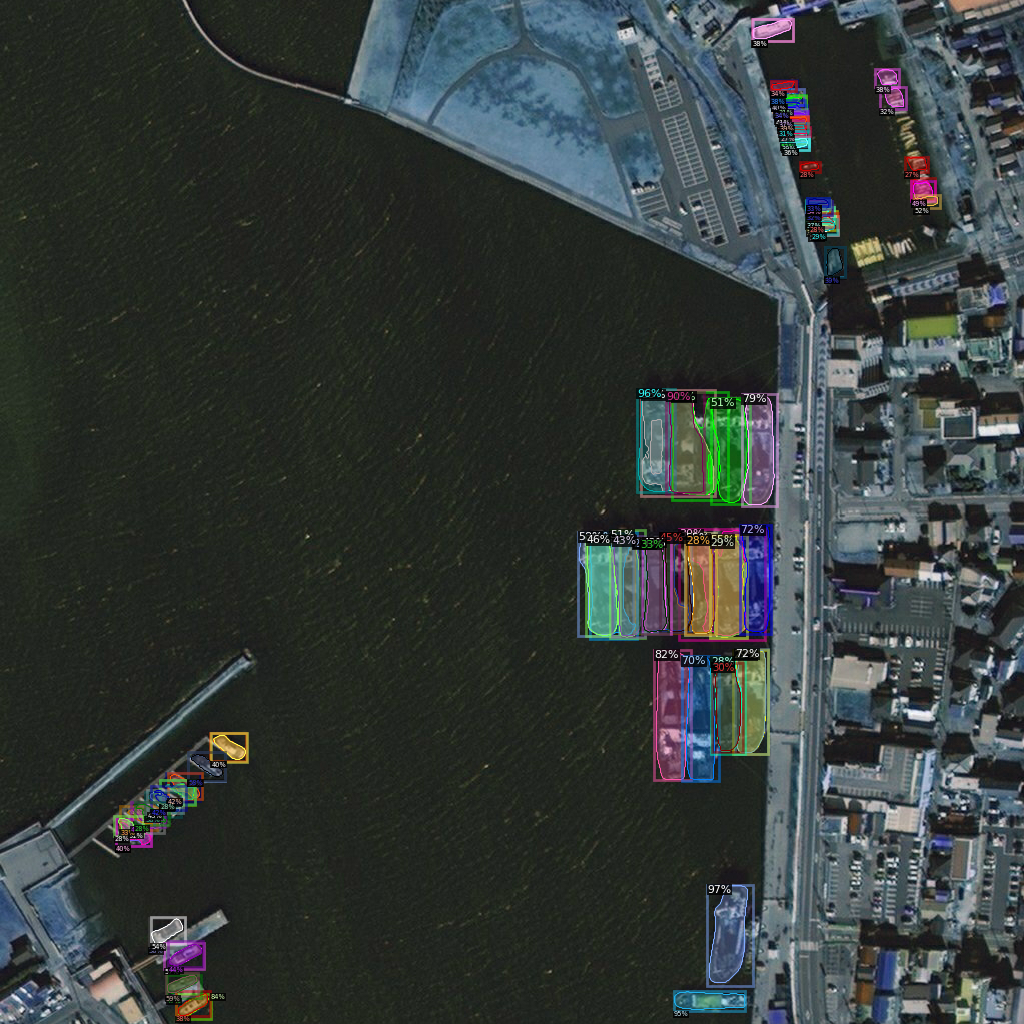

In [11]:
img_id = 186
im = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
#                metadata=fruits_nuts_metadata, 
               scale=1, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(v.get_image()[:, :, ::-1])

# 2 gen 5 results

In [12]:
timg1 = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')

outputs1 = predictor(timg1)
outputs2 = predictor(np.flip(timg1,0))
outputs3 = predictor(np.rollaxis(timg1,0,2))
outputs4 = predictor(np.rot90(timg1,2))
outputs5 = predictor(np.rot90(timg1,3))

types= [ [] for i in range(5) ]

results_image = outputs1['instances'].to("cpu")

for annos in range(0,len(results_image)):
    instance = results_image[annos]
    
    bolean_mask = instance.get('pred_masks')
    mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
    area = np.sum(mask)
    
    confidence = float(instance.get('scores'))
    anno_class = int(instance.get('pred_classes'))
    confient_mask = confidence*40*mask
    
    
    types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])
    
results_image = outputs2['instances'].to("cpu")

for annos in range(0,len(results_image)):
    instance = results_image[annos]
    
    bolean_mask = instance.get('pred_masks')
    mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
    mask = np.flip((mask),0)
    area = np.sum(mask)
    
    confidence = float(instance.get('scores'))
    anno_class = int(instance.get('pred_classes'))
    confient_mask = confidence*40*mask
    
    
    types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])
    
    
results_image = outputs3['instances'].to("cpu")

for annos in range(0,len(results_image)):
    instance = results_image[annos]
    
    bolean_mask = instance.get('pred_masks')
    mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
    mask = np.rollaxis(mask,0,2)
    area = np.sum(mask)
    
    confidence = float(instance.get('scores'))
    anno_class = int(instance.get('pred_classes'))
    confient_mask = confidence*40*mask
    
    
    types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])
    
results_image = outputs4['instances'].to("cpu")    

for annos in range(0,len(results_image)):
    instance = results_image[annos]
    
    bolean_mask = instance.get('pred_masks')
    mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
    mask = np.rot90((mask),2)
    area = np.sum(mask)
    
    confidence = float(instance.get('scores'))
    anno_class = int(instance.get('pred_classes'))
    confient_mask = confidence*40*mask
    
    
    types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])
    
results_image = outputs5['instances'].to("cpu")
    
for annos in range(0,len(results_image)):
    instance = results_image[annos]
    
    bolean_mask = instance.get('pred_masks')
    mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
    mask = np.rot90((mask),1)
    area = np.sum(mask)
    
    confidence = float(instance.get('scores'))
    anno_class = int(instance.get('pred_classes'))
    confient_mask = confidence*10*mask
    
    
    types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])
    
types_1 = copy.deepcopy(types)

cofi_mask = []
i = 0
for classes in types:
    
    total_cofi_mask = np.zeros((1024,1024),dtype = np.float64)
    for anno_item in classes:
        total_cofi_mask = total_cofi_mask + anno_item[1]
#         print(i)
#         print('type = ' + str(anno_item[2]))
#     print(total_cofi_mask.max())
    cofi_mask.append(total_cofi_mask)
    

for classes in types:
    
    for anno_item in classes:
#         print(anno_item[2])
        if(anno_item[2] <= 4):
            anno_item.append(np.sum(cofi_mask[anno_item[2]-1]* anno_item[0]) / anno_item[4]* (anno_item[3]**2))
        else:
#             print('1')
            anno_item.append(np.sum(cofi_mask[anno_item[2]-1]* anno_item[0]) / anno_item[4]* (anno_item[3]**2)*0.5)

types_1 = copy.deepcopy(types)

# 3 append same class results

In [ ]:
append_thres = 0.4
final_masks  = []
types = copy.deepcopy(types_1)

for classes in types:
# for classes in [types[3]]: 
    pop_item = []
    total_cofi_mask = np.zeros((1024,1024))
    for anno_item in classes:
        total_cofi_mask = total_cofi_mask + anno_item[1]
    anno_item = 0
    classes2 = copy.deepcopy(classes)
#     print('len->',len(classes))
    if_delet =False
    while( len(classes2)!= anno_item):
#         print(pop_id)
        if_delet =False
#         print(len(classes))
#         print(anno_item)
#         print(jump)
        itself = classes2[anno_item]
        temp_classes = copy.deepcopy(classes2)
        temp_classes.pop(anno_item)
        for temp_item in temp_classes:
            if(if_delet ==False):
                append_mask = temp_item[0]+ itself[0]

                append_area = np.sum(append_mask>1)
                temp_thres = append_thres*(itself[4])
    #             print(append_area)
    #             print(temp_thres)
                temp_thres2 = append_thres*(temp_item[4])
                if(append_area > temp_thres or  append_area> temp_thres2 ):

    #                 print(append_area)
    #                 t1 = np.sum(cofi_mask[itself[2]-1]* itself[0]) / itself[4]* (itself[3]**1.5)
    #                 print(t1)
    #                 t2 = np.sum(cofi_mask[temp_item[2]-1]* temp_item[0]) /temp_item[4]* (temp_item[3]**1.5)
                    t1 = itself[5]
    #                 print(t1)
                    t2 = temp_item[5]

    #                 print(t1,t2)
                    if((t1) < (t2)):

                        pop_item.append(anno_item)
                        if_delet = True
    #                     print('pop')

        anno_item+=1

        

    l2 = list(set(pop_item))
    l2.sort(key=pop_item.index)
    for anno_item in range(len(l2)-1,-1,-1):   
        classes.pop(l2[anno_item])

#                     anno_item = anno_item-1
#                     print('pop')
#                     continue
#         print((len(classes) - anno_item))
#         if((len(classes) - anno_item) == 0):
#             print('!!')
#             jump = 100
            

        

    for anno_item in classes:
        final_masks.append(anno_item)

final_masks_temp1 = copy.deepcopy(final_masks)

In [ ]:
len(final_masks_temp1)

# 4 append different type results

In [7]:
append_thres = 0.5
anno_item = 0
pop_item = []
# final_masks = copy.deepcopy(final_masks_1)

final_masks = copy.deepcopy(final_masks_temp1)
final_masks2= copy.deepcopy(final_masks)

while(len(final_masks2)!= anno_item):
#     print(anno_item)

    itself = copy.deepcopy(final_masks2[anno_item])
    temp_classes = copy.deepcopy(final_masks2)
    temp_classes.pop(anno_item)
    for temp_item in temp_classes:
        append_mask = temp_item[0]+ itself[0]

        append_area = np.sum(append_mask>1)
        temp_thres = append_thres*(itself[4])
        temp_thres2 = append_thres*(temp_item[4])
#         print(append_area)
#         print(temp_thres)
        if(append_area > temp_thres or append_area> temp_thres2  ):
            t1 = itself[5]
            t2 = temp_item[5]
#             print(itself[3],temp_item[3])
#             print(itself[4],temp_item[4])
            if((t1) < (t2)):
#                 print(append_area)
#                 print(temp_thres)
                pop_item.append(anno_item)
#                 anno_item = anno_item-1

    anno_item+=1

    
l2 = list(set(pop_item))
l2.sort(key=pop_item.index)
for anno_item in range(len(l2)-1,-1,-1):   
    final_masks.pop(l2[anno_item])
    

In [ ]:
len(final_masks)

In [ ]:
final_masks1 = copy.deepcopy(final_masks)
for item in final_masks1:  
    item.append((np.sum(cofi_mask[item[2]-1]* item[0]) / item[4]))

In [ ]:
final_masks1[0][5]

In [9]:
from skimage import measure
def find_contours(img1):
    contours = measure.find_contours(img1, 0.8)
    maxim = 0
    ct = []
    for i in contours: 
        if(len(i)>maxim):
            ct = []
            for ii in i:
                ct.append((round(ii[1]),round(ii[0])))
            maxim = len(i)
    return ct


In [ ]:
mask = np.zeros((1024,1024))
for item in final_masks:
    mask += item[0]
im2 = copy.deepcopy(im)
im2 = np.asarray(im2, dtype = np.int16)
plt.figure(figsize=(18,18)) 
plt.imshow(im)

# 5 check final results

In [ ]:
ct1 = []
for item in final_masks:  
    
#     final_confidence  = (np.sum(cofi_mask[item[2]-1]* item[0]) / item[4])
    final_confidence =item[5]

    print(final_confidence)
    print(item[2])
    if(final_confidence>0):
        ct1.append(np.asarray(find_contours(item[0])))

plt.figure(figsize=[17,17])
plt.imshow(im,cmap='gray')
for item in ct1:
    try:
        plt.plot(item[:,0],item[:,1],'r',linewidth=3)
    except:
        pass
plt.axis('off')

In [ ]:
ct1 = []
for item in total_array[img_id-1]:  
    
#     final_confidence  = np.sum(cofi_mask[item[2]-1]* item[0])
    
    final_confidence = item[5]*item[3]
    
    if (final_confidence>50):
#         ct1.append(np.asarray(find_contours(item[0])))
        ct1.append(np.asarray(find_contours(item[0])))
    


plt.figure(figsize=[17,17])
plt.imshow(im,cmap='gray')
for item in ct1:
    try:
        plt.plot(item[:,0],item[:,1],'r',linewidth=3)
    except:
        pass
plt.axis('off')

In [ ]:

ct1 = []
for item in final_masks:  
    
    cts = (np.asarray(find_contours(item[0])))
    ct1.append
#     print(item[2])
#     print(item[3])
    final_confidence  = np.sum(cofi_mask[item[2]-1]* item[0])
    plt.figure(figsize=[17,17])
    plt.imshow(im,cmap='gray')
    plt.plot(cts[:,0],cts[:,1],'r--',linewidth=3)
    plt.title(str(item[2]) + '  '+ str(round(item[3],5))+ '  '+ str(round(final_confidence,5)))
    plt.axis('off')

# plt.figure(figsize=[17,17])
# plt.imshow(im,cmap='gray')
# for item in ct1:
#     plt.plot(item[:,0],item[:,1],'r--',linewidth=3)

# plt.axis('off')


In [ ]:
plt.imshow(final_masks[3][0] + final_masks[2][0])

In [ ]:
len(outputs[0])

In [ ]:
_,contours,_ = cv2.findContours(mask.copy(), 1, 1) # not copying here will throw an error
rect = cv2.minAreaRect(contours[0]) # basically you can feed this rect into your classifier
(x,y),(w,h), a = rect # a - angle

In [ ]:
predictor(im)

In [ ]:

d = dataset_dicts[3]
im = cv2.imread(d["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
#                metadata=fruits_nuts_metadata, 
               scale=1.4, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(v.get_image()[:, :, ::-1])

In [ ]:
res_mask = outputs['instances'].to("cpu")[3].pred_masks[0]

In [ ]:
float(outputs['instances'].to("cpu")[3].scores[0])

In [ ]:
outputs['instances'].to("cpu")[3]

In [ ]:
Image.fromarray(np.asarray(res_mask,dtype = np.uint8)*255)

In [ ]:
from detectron2.evaluation import COCOEvaluator, RotatedCOCOEvaluator
from detectron2.engine.defaults import DefaultPredictor,DefaultTrainer,inference_on_dataset
from detectron2.engine import tr

In [ ]:
evaluator = COCOEvaluator("boat_val", cfg , False, output_dir=None)

In [ ]:
Rotatedevaluator = RotatedCOCOEvaluator("boat_val", cfg , False, output_dir=None)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# DefaultTrainer.resume_or_load(resume=True)
# model = build_model(cfg)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
val_loader = build_detection_test_loader(cfg, "boat_val")

In [ ]:
inference_on_dataset(trainer.model, val_loader, Rotatedevaluator)

In [ ]:
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
a = 90
np.random.randint(-a,a,[10,10])

In [ ]:
x = np.ones((10,10),dtype = np.uint8)*210 
y = (x + np.random.randint(-a,a,[10,10]))

In [ ]:
y[y>255] = 255

In [ ]:
def find_conf_mask(img_id):
    timg1 = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')

    outputs1 = predictor(timg1)
    outputs2 = predictor(np.flip(timg1,0))
    outputs3 = predictor(np.rollaxis(timg1,0,2))
    outputs4 = predictor(np.rot90(timg1,2))
    outputs5 = predictor(np.rot90(timg1,3))

    types= [ [] for i in range(5) ]

    results_image = outputs1['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    results_image = outputs2['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.flip((mask),0)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])


    results_image = outputs3['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.rollaxis(mask,0,2)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    results_image = outputs4['instances'].to("cpu")    

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.rot90((mask),2)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    results_image = outputs5['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.rot90((mask),1)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    types_1 = copy.deepcopy(types)

    cofi_mask = []
    i = 0
    for classes in types:

        total_cofi_mask = np.zeros((1024,1024))
        for anno_item in classes:
            total_cofi_mask = total_cofi_mask + anno_item[1]
    #         print(i)
    #         print('type = ' + str(anno_item[2]))
        cofi_mask.append(total_cofi_mask)
    return cofi_mask

# finall code for all images

In [27]:
total_array = []
for img_id in range(1,261):
    timg1 = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')

    outputs1 = predictor(timg1)
    outputs2 = predictor(np.flip(timg1,0))
    outputs3 = predictor(np.rollaxis(timg1,0,2))
    outputs4 = predictor(np.rot90(timg1,2))
    outputs5 = predictor(np.rot90(timg1,3))

    types= [ [] for i in range(5) ]

    results_image = outputs1['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    results_image = outputs2['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.flip((mask),0)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])


    results_image = outputs3['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.rollaxis(mask,0,2)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    results_image = outputs4['instances'].to("cpu")    

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.rot90((mask),2)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*40*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    results_image = outputs5['instances'].to("cpu")

    for annos in range(0,len(results_image)):
        instance = results_image[annos]

        bolean_mask = instance.get('pred_masks')
        mask = np.asarray(bolean_mask,dtype  = np.uint8).reshape(bolean_mask.shape[1],bolean_mask.shape[2])
        mask = np.rot90((mask),1)
        area = np.sum(mask)

        confidence = float(instance.get('scores'))
        anno_class = int(instance.get('pred_classes'))
        confient_mask = confidence*10*mask


        types[anno_class-1].append([mask, confient_mask, anno_class, confidence, area])

    types_1 = copy.deepcopy(types)

    cofi_mask = []
    i = 0
    for classes in types:

        total_cofi_mask = np.zeros((1024,1024),dtype = np.float64)
        for anno_item in classes:
            total_cofi_mask = total_cofi_mask + anno_item[1]
    #         print(i)
    #         print('type = ' + str(anno_item[2]))
    #     print(total_cofi_mask.max())
        cofi_mask.append(total_cofi_mask)


    for classes in types:

        for anno_item in classes:
    #         print(anno_item[2])
            if(anno_item[2] <= 4):
                anno_item.append(np.sum(cofi_mask[anno_item[2]-1]* anno_item[0]) / anno_item[4]* (anno_item[3]**2))
            else:
    #             print('1')
                anno_item.append(np.sum(cofi_mask[anno_item[2]-1]* anno_item[0]) / anno_item[4]* (anno_item[3]**2)*0.5)

    types_1 = copy.deepcopy(types)

    append_thres = 0.4
    final_masks  = []
    types = copy.deepcopy(types_1)

    for classes in types:
    # for classes in [types[3]]: 
        pop_item = []
        total_cofi_mask = np.zeros((1024,1024))
        for anno_item in classes:
            total_cofi_mask = total_cofi_mask + anno_item[1]
        anno_item = 0
        classes2 = copy.deepcopy(classes)
    #     print('len->',len(classes))
        if_delet =False
        while( len(classes2)!= anno_item):
    #         print(pop_id)
            if_delet =False
    #         print(len(classes))
    #         print(anno_item)
    #         print(jump)
            itself = classes2[anno_item]
            temp_classes = copy.deepcopy(classes2)
            temp_classes.pop(anno_item)
            for temp_item in temp_classes:
                if(if_delet ==False):
                    append_mask = temp_item[0]+ itself[0]

                    append_area = np.sum(append_mask>1)
                    temp_thres = append_thres*(itself[4])
        #             print(append_area)
        #             print(temp_thres)
                    temp_thres2 = append_thres*(temp_item[4])
                    if(append_area > temp_thres or  append_area> temp_thres2 ):

        #                 print(append_area)
        #                 t1 = np.sum(cofi_mask[itself[2]-1]* itself[0]) / itself[4]* (itself[3]**1.5)
        #                 print(t1)
        #                 t2 = np.sum(cofi_mask[temp_item[2]-1]* temp_item[0]) /temp_item[4]* (temp_item[3]**1.5)
                        t1 = itself[5]
        #                 print(t1)
                        t2 = temp_item[5]

        #                 print(t1,t2)
                        if((t1) < (t2)):

                            pop_item.append(anno_item)
                            if_delet = True
        #                     print('pop')

            anno_item+=1



        l2 = list(set(pop_item))
        l2.sort(key=pop_item.index)
        for anno_item in range(len(l2)-1,-1,-1):   
            classes.pop(l2[anno_item])

    #                     anno_item = anno_item-1
    #                     print('pop')
    #                     continue
    #         print((len(classes) - anno_item))
    #         if((len(classes) - anno_item) == 0):
    #             print('!!')
    #             jump = 100




        for anno_item in classes:
            final_masks.append(anno_item)

    final_masks_temp1 = copy.deepcopy(final_masks)

    append_thres = 0.5
    anno_item = 0
    pop_item = []
    # final_masks = copy.deepcopy(final_masks_1)

    final_masks = copy.deepcopy(final_masks_temp1)
    final_masks2= copy.deepcopy(final_masks)

    while(len(final_masks2)!= anno_item):
    #     print(anno_item)

        itself = copy.deepcopy(final_masks2[anno_item])
        temp_classes = copy.deepcopy(final_masks2)
        temp_classes.pop(anno_item)
        for temp_item in temp_classes:
            append_mask = temp_item[0]+ itself[0]

            append_area = np.sum(append_mask>1)
            temp_thres = append_thres*(itself[4])
            temp_thres2 = append_thres*(temp_item[4])
    #         print(append_area)
    #         print(temp_thres)
            if(append_area > temp_thres or append_area> temp_thres2  ):
                t1 = itself[5]
                t2 = temp_item[5]
    #             print(itself[3],temp_item[3])
    #             print(itself[4],temp_item[4])
                if((t1) < (t2)):
    #                 print(append_area)
    #                 print(temp_thres)
                    pop_item.append(anno_item)
    #                 anno_item = anno_item-1

        anno_item+=1


    l2 = list(set(pop_item))
    l2.sort(key=pop_item.index)
    for anno_item in range(len(l2)-1,-1,-1):   
        final_masks.pop(l2[anno_item])
    
    
    total_array.append(final_masks)

In [ ]:
for img_id in range(10,13):

    timg1 = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')
    ct1 = []
    for item in total_array[img_id-10]:  

        final_confidence  = np.sum(cofi_mask[item[2]-1]* item[0])
        ct1.append(np.asarray(find_contours(item[0])))




    plt.figure(figsize=[17,17])
    plt.imshow(timg1,cmap='gray')
    for item in ct1:
        try:
            plt.plot(item[:,0],item[:,1],'r--',linewidth=3)
        except:
            pass
    plt.axis('off')

In [28]:
np.save('16999', total_array)

In [ ]:
for img_id in range(10,13):

    timg1 = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')
    ct1 = []
    for item in total_array[img_id-10]:  

        final_confidence  = np.sum(cofi_mask[item[2]-1]* item[0])
        ct1.append(np.asarray(find_contours(item[0])))




    plt.figure(figsize=[17,17])
    plt.imshow(timg1,cmap='gray')
    for item in ct1:
        try:
            plt.plot(item[:,0],item[:,1],'r--',linewidth=3)
        except:
            pass
    plt.axis('off')

In [16]:
def rotated_bbox(mask):
    contours,_ = cv2.findContours(mask.copy(), 1, 1) # not copying here will throw an error
#     print(contours)
#     print(_)
    rect = cv2.minAreaRect(contours[0]) # basically you can feed this rect into your classifier
    (x,y),(w,h), a = rect # a - angle
    box = cv2.boxPoints(rect)
    box = np.int0(box) 
    return box

In [ ]:
# for img_id in range(179,180):
img_id = 20
color_ct = []
#     cofi_mask = find_conf_mask(img_id)
timg1 = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')
ct1 = []
for item in total_array[img_id-1]:  

#         final_confidence  = np.sum(cofi_mask[item[2]-1]* item[0] / item[4])
    final_confidence = item[5]*item[3]
    if (final_confidence>50):
#         ct1.append(np.asarray(find_contours(item[0])))
        ct1.append(rotated_bbox(item[0]))
        ct1_type = item[2]
        if(ct1_type ==1):
            ct1_type = 'r'
        if(ct1_type ==2):
            ct1_type = 'b'
        if(ct1_type ==3):
            ct1_type = 'g'
        if(ct1_type ==4):
            ct1_type = 'y'
        if(ct1_type ==5):
            ct1_type = 'w'
        print(ct1_type)
        color_ct.append(ct1_type)

plt.figure(figsize=[17,17])
plt.imshow(timg1,cmap='gray')
for item in range(0,len(ct1)):
    
    plt.plot(np.append(ct1[item][:,0],ct1[item][:,0][0]),np.append(ct1[item][:,1],ct1[item][:,1][0]),color_ct[item],linewidth=3)

plt.axis('off')

In [22]:
len(total_array)

3

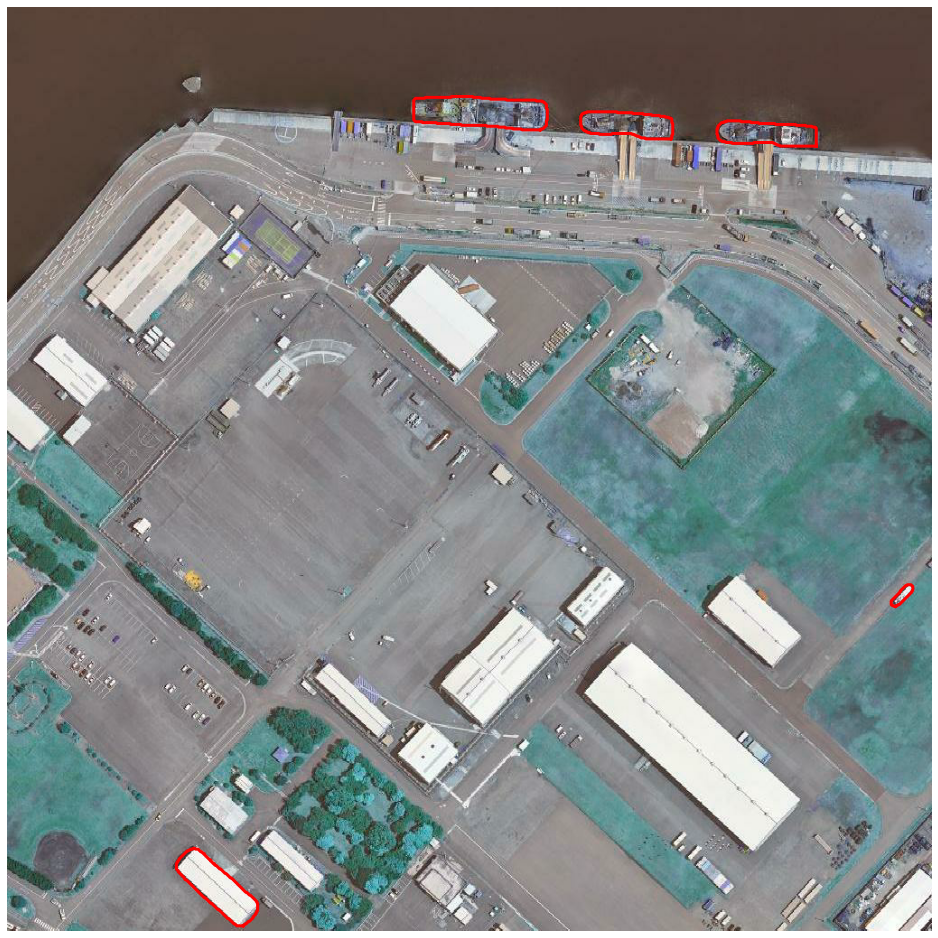

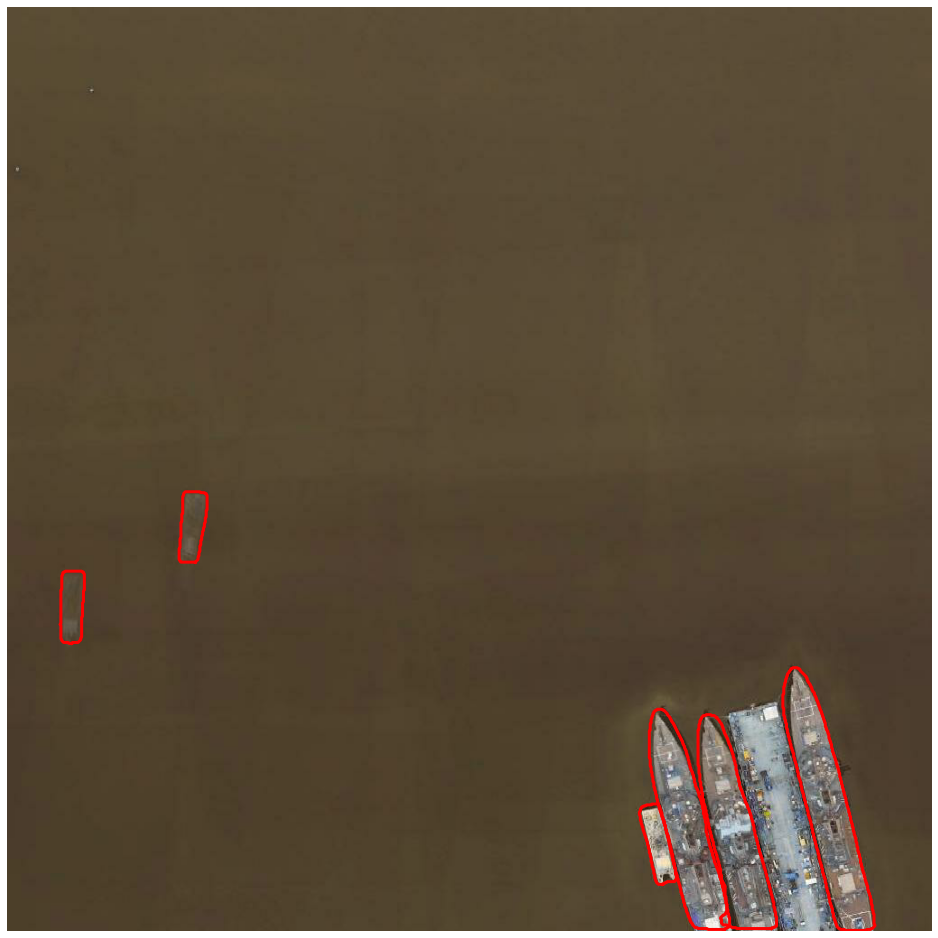

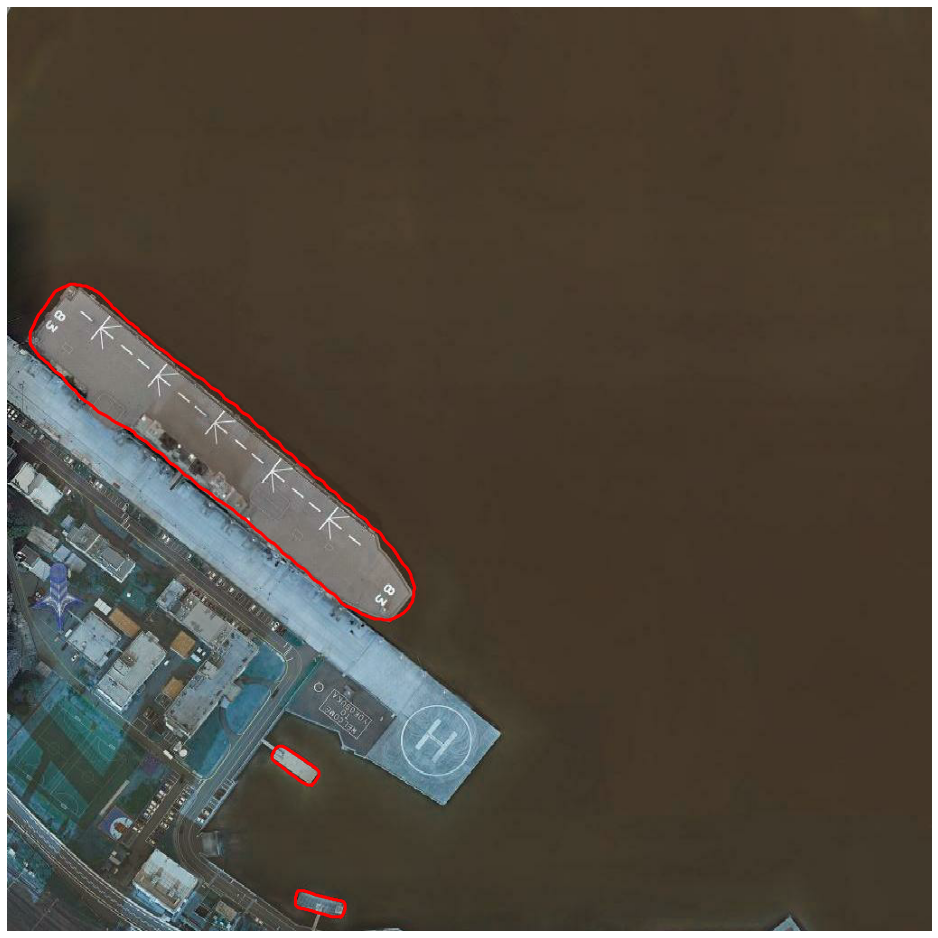

In [26]:
ct2 = []
for img_id in range(1,4):
    ct1  = []
#     cofi_mask = find_conf_mask(img_id)
    timg1 = cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif')

    for item in total_array[img_id-1]:  

#         final_confidence  = np.sum(cofi_mask[item[2]-1]* item[0] / item[4])
        final_confidence = item[5]
        if (final_confidence>4):
            ct1.append(np.asarray(find_contours(item[0])))
            cords = (rotated_bbox(item[0]))
            ct2.append([str(img_id)+'.tif', item[2], round(item[3],5), cords[0][0], cords[0][1], cords[1][0], cords[1][1], cords[2][0], cords[2][1], cords[3][0], cords[3][1]])


    plt.figure(figsize=[17,17])
    plt.imshow(timg1,cmap='gray')
    for item in ct1:
        
        plt.plot(np.append(item[:,0],item[:,0][0]),np.append(item[:,1],item[:,1][0]),'r',linewidth=3)

    plt.axis('off')

In [18]:
item

['1.tif', 3, 0.97583, 736, 148, 633, 138, 635, 111, 738, 121]

In [ ]:
with open("file.txt", "w") as output:
    output.write(str(ct1))

In [ ]:
ct1 = np.asarray(ct1)

In [ ]:
np.savetxt('results.txt', ct1, delimiter = ' ' ,fmt='%s')

In [ ]:
plt.figure(figsize=[17,17])
plt.imshow(cv2.imread('/home/q/4t/detectron2/a/test/' + str(img_id)+'.tif'),cmap='gray')
for item in ct1:

    plt.plot([item[3],item[5],item[7],item[9]],[item[4],item[6],item[8],item[10]],'r',linewidth=3)

plt.axis('off')

In [ ]:
item[10]

In [ ]:
str(img_id)+'.tif'

In [ ]:
final_confidence,confident_temp = [],[]
# cofi_mask = find_conf_mask(img_id)
for item in total_array[img_id-1]:  

#     final_confidence.append(np.sum(cofi_mask[item[2]-1]* item[0])) /  item[4]
    final_confidence.append(item[5]*item[3])
    confident_temp.append(item[3])
#         ct1.append(np.asarray(find_contours(item[0])))
#     ct1.append(rotated_bbox(item[0]))

In [ ]:
final_confidence
# confident_temp

In [ ]:
final_confidence

In [ ]:
item[5]

In [ ]:
plt.imshow(cofi_mask[item[2]-1])

In [ ]:
ct1 = []
for item in total_array[img_id-3]:  
    
    cts = rotated_bbox(item[0])
#     print(item[2])
#     print(item[3])
#     for item in cts:
#         final_confidence  = np.sum(cofi_mask[item[2]-1]* item[0])
    plt.figure(figsize=[17,17])
    plt.imshow(im,cmap='gray')
    plt.plot(np.append(cts[:,0],cts[:,0][0]),np.append(cts[:,1],cts[:,1][0]),'r',linewidth=3)
    plt.title(str(item[2]) + '  '+ str(round(item[3],5))+ '  '+ str(round(final_confidence,5)))
    plt.axis('off')

In [ ]:
np.append(item[:,0],item[:,0])

In [516]:
cts

array([[672, 206],
       [661, 184],
       [796, 116],
       [807, 137]])

In [520]:
item[]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
if(np.sum(item ==0) ==1):
    x,y = np.index(item ==0)
    

In [ ]:
from imantics import Polygons, Mask

polygons = Mask((item[0])).polygons()

In [ ]:
print(polygons.segmentation)

